(multi_hyper_v7)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 多元超几何分布

```{contents} 目录
:depth: 2
```

## 概述

本讲解介绍了一位管理者如何运用**多元超几何分布**来评估研究基金分配程序的公平性。

在本讲中，我们将学习：

* 多元超几何分布的性质
* 多元超几何分布的一阶和二阶矩

* 使用多元正态分布的蒙特卡洛模拟来评估正态近似的质量
* 管理员的问题以及为什么多元超几何分布是正确的工具

## 管理员的问题

一位负责分配研究基金的管理员面临以下情况。

为了帮助我们忽略与此无关的细节，并保护管理员和相关人员的匿名性，我们将研究提案称为**球**，将提案作者所在的大洲称为**颜色**。

有 $K_i$ 个颜色为 $i$ 的球（提案）。

有 $c$ 种不同的颜色（大洲）。

因此，$i = 1, 2, \ldots, c$

所以总共有 $N = \sum_{i=1}^c K_i$ 个球。

所有这 $N$ 个球被放入一个箱子中。

然后随机抽取 $n$ 个球。

选拔程序应该是**色盲的**，这意味着**球的质量**这一随机变量应该与**球的颜色**无关，决定一个球是否被抽中。

因此，选拔程序应该从箱子中随机抽取$n$个球。

这$n$个被抽中的球代表成功的提案，将获得研究资金。

剩余的$N-n$个球不会获得研究资金。

### 研究中的奖励程序细节

令$k_i$为抽取的颜色$i$的球的数量。

总数必须相加，所以$\sum_{i=1}^c k_i = n$。

在假设选拔过程根据提案质量进行判断，且质量与作者所在大洲无关的前提下，管理者将选拔程序的结果视为一个随机向量

$$
X = \begin{pmatrix} k_1 \cr k_2 \cr \vdots \cr k_c \end{pmatrix}.
$$

为了评估选择程序是否**色盲**，管理员想研究所抽取的$X$的特定实现是否可以合理地被认为是从**色盲**假设所暗示的概率分布中随机抽取的。

适当的概率分布是[这里](https://en.wikipedia.org/wiki/Hypergeometric_distribution)所描述的分布。

让我们现在具体化管理员的问题，同时继续使用彩色球的比喻。

管理员有一个装有$N = 238$个球的罐子。

157个球是蓝色的，11个球是绿色的，46个球是黄色的，24个球是黑色的。

所以$(K_1, K_2, K_3, K_4) = (157 , 11 , 46 , 24)$且$c = 4$。

不放回地抽取15个球。

所以$n = 15$。

管理员想知道结果的概率分布

$$
X = \begin{pmatrix} k_1 \cr k_2 \cr \vdots \cr k_4 \end{pmatrix}.
$$

特别地，他想知道一个特定的

结果 - 以一个 $4 \times 1$ 的整数向量形式记录蓝色、绿色、黄色和黑色球的数量 - 包含了反对选择过程是*公平*的证据，这里*公平*意味着*色盲*且确实是从 $N$ 个球的总体中进行的无放回随机抽取。

管理员的正确工具是**多元超几何分布**。

### 多元超几何分布

让我们从一些导入开始。

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  #设置默认图形大小
import numpy as np
from scipy.special import comb
from scipy.stats import normaltest
from numba import jit, prange

总的来说，我们假设在一个坛子里总共有$c$种物品。

如果坛子里有$K_{i}$个第$i$种物品，我们不放回地随机抽取$n$次，那么样本中第$i$种物品的数量$(k_{1},k_{2},\dots,k_{c})$服从多元超几何分布。

再次注意，$N=\sum_{i=1}^{c} K_{i}$是坛子中物品的总数，且$n=\sum_{i=1}^{c}k_{i}$。

**符号说明**

我们使用以下符号表示**二项式系数**：${m \choose q} = \frac{m!}{(m-q)!}$。

多元超几何分布具有以下性质：

**概率质量函数**：

$$
\Pr \{X_{i}=k_{i} \  \forall i\} =
 \frac {\prod _{i=1}^{c}{\binom {K_{i}}{k_{i}}}}{\binom {N}{n}}
$$

**期望值**：

$$
{\displaystyle \operatorname {E} (X_{i})=n{\frac {K_{i}}{N}}}
$$

**方差和协方差**：

$$
{\displaystyle \operatorname {Var} (X_{i})=n{\frac {N-n}{N-1}}\;{\frac {K_{i}}{N}}\left(1-{\frac {K_{i}}{N}}\right)}
$$

{\displaystyle \operatorname {Cov} (X_{i},X_{j})=-n{\frac {N-n}{N-1}}\;{\frac {K_{i}}{N}}{\frac {K_{j}}{N}}}
$$

为了帮我们完成工作，我们将编写一个`Urn`类。

In [2]:
class Urn:

    def __init__(self, K_arr):
        """
        根据坛子中每种类型i物体的数量进行初始化。

        参数
        ----------
        K_arr: ndarray(int)
            每种类型i物体的数量。
        """

        self.K_arr = np.array(K_arr)
        self.N = np.sum(K_arr)
        self.c = len(K_arr)

    def pmf(self, k_arr):
        """
        概率质量函数。

        参数
        ----------
        k_arr: ndarray(int)
            每种物体观察到的成功次数。
        """

        K_arr, N = self.K_arr, self.N

        k_arr = np.atleast_2d(k_arr)
        n = np.sum(k_arr, 1)

        num = np.prod(comb(K_arr, k_arr), 1)
        denom = comb(N, n)

        pr = num / denom

        return pr

    def moments(self, n):
        """
        计算多元超几何分布的均值和方差-协方差矩阵。

        参数
        ----------
        n: int
            抽取次数。
        """

        K_arr, N, c = self.K_arr, self.N, self.c

        # 均值
        μ = n * K_arr / N

        # 方差-协方差矩阵
        Σ = np.full((c, c), n * (N - n) / (N - 1) / N ** 2)
        for i in range(c-1):
            Σ[i, i] *= K_arr[i] * (N - K_arr[i])
            for j in range(i+1, c):
                Σ[i, j] *= - K_arr[i] * K_arr[j]
                Σ[j, i] = Σ[i, j]

        Σ[-1, -1] *= K_arr[-1] * (N - K_arr[-1])

        return μ, Σ

    def simulate(self, n, size=1, seed=None):
        """
        从多元超几何分布中模拟样本，每次抽取时
        从坛子中不放回地取出n个物体。

        参数
        ----------
        n: int
            每次抽取的物体数量。
        size: int(可选)
            样本大小。
        seed: int(可选)
            随机种子。
        """

        K_arr = self.K_arr

        gen = np.random.Generator(np.random.PCG64(seed))
        sample = gen.multivariate_hypergeometric(K_arr, n, size=size)

        return sample

## 使用方法

### 第一个例子

应用这个例子，来自[维基百科](https://en.wikipedia.org/wiki/Hypergeometric_distribution#Multivariate_hypergeometric_distribution)：

假设一个骨灰盒中有5个黑色、10个白色和15个红色的弹珠。如果不放回地抽取六个弹珠，抽到每种颜色各两个的概率是

$$
P(2{\text{ 黑色}},2{\text{ 白色}},2{\text{ 红色}})={{{5 \choose 2}{10 \choose 2}{15 \choose 2}} \over {30 \choose 6}}=0.079575596816976
$$

In [3]:
# 构造骨灰盒
K_arr = [5, 10, 15]
urn = Urn(K_arr)

现在使用 Urn 类的 `pmf` 方法来计算结果 $X = \begin{pmatrix} 2 & 2 & 2 \end{pmatrix}$ 的概率

In [4]:
k_arr = [2, 2, 2] # 观察到成功次数的数组
urn.pmf(k_arr)

array([0.0795756])

我们可以通过构建一个二维数组`k_arr`来计算一系列可能结果的概率，`pmf`将返回一个数组，包含观察到每种情况的概率。

In [5]:
k_arr = [[2, 2, 2], [1, 3, 2]]
urn.pmf(k_arr)

array([0.0795756, 0.1061008])

现在让我们计算均值向量和方差-协方差矩阵。

In [6]:
n = 6
μ, Σ = urn.moments(n)

In [7]:
μ

array([1., 2., 3.])

In [8]:
Σ

array([[ 0.68965517, -0.27586207, -0.4137931 ],
       [-0.27586207,  1.10344828, -0.82758621],
       [-0.4137931 , -0.82758621,  1.24137931]])

### 回到管理员的问题

现在让我们回到拨款管理员的问题。

这里在箱子里的$i$个物品的数组是
$\left(157, 11, 46, 24\right)$。

In [9]:
K_arr = [157, 11, 46, 24]
urn = Urn(K_arr)

让我们计算结果 $\left(10, 1, 4, 0 \right)$ 的概率。

In [10]:
k_arr = [10, 1, 4, 0]
urn.pmf(k_arr)

array([0.01547738])

我们可以通过构建一个3维数组`k_arr`并使用`Urn`类的`pmf`方法来计算三种可能结果的概率。

In [11]:
k_arr = [[5, 5, 4 ,1], [10, 1, 2, 2], [13, 0, 2, 0]]
urn.pmf(k_arr)

array([6.21412534e-06, 2.70935969e-02, 1.61839976e-02])

现在让我们计算当 $n=6$ 时 $X$ 的均值和方差-协方差矩阵。

In [12]:
n = 6 # 抽取次数
μ, Σ = urn.moments(n)

In [13]:
# 均值
μ

array([3.95798319, 0.27731092, 1.15966387, 0.60504202])

In [14]:
# 方差-协方差矩阵
Σ

array([[ 1.31862604, -0.17907267, -0.74884935, -0.39070401],
       [-0.17907267,  0.25891399, -0.05246715, -0.02737417],
       [-0.74884935, -0.05246715,  0.91579029, -0.11447379],
       [-0.39070401, -0.02737417, -0.11447379,  0.53255196]])

我们可以模拟一个大样本，并验证样本均值和协方差与总体均值和协方差非常接近。

In [15]:
size = 10_000_000
sample = urn.simulate(n, size=size)

In [16]:
# 均值
np.mean(sample, 0)

array([3.9580298, 0.2771187, 1.1594239, 0.6054276])

In [17]:
# 方差协方差矩阵
np.cov(sample.T)

array([[ 1.31871903, -0.17888019, -0.74893942, -0.39089942],
       [-0.17888019,  0.25875755, -0.05233855, -0.02753881],
       [-0.74893942, -0.05233855,  0.91562801, -0.11435004],
       [-0.39089942, -0.02753881, -0.11435004,  0.53278827]])

显然，样本均值和协方差很好地近似了它们的总体对应值。

### 正态近似的质量

为了判断多元正态分布对多元超几何分布的近似质量，我们从具有相应多元超几何分布的均值向量和协方差矩阵的多元正态分布中抽取大量样本，并将模拟分布与总体多元超几何分布进行比较。

In [18]:
sample_normal = np.random.multivariate_normal(μ, Σ, size=size)

In [19]:
def bivariate_normal(x, y, μ, Σ, i, j):

    μ_x, μ_y = μ[i], μ[j]
    σ_x, σ_y = np.sqrt(Σ[i, i]), np.sqrt(Σ[j, j])
    σ_xy = Σ[i, j]

    x_μ = x - μ_x
    y_μ = y - μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)

    return np.exp(-z / (2 * (1 - ρ**2))) / denom

In [20]:
@jit
def count(vec1, vec2, n):
    size = sample.shape[0]

    count_mat = np.zeros((n+1, n+1))
    for i in prange(size):
        count_mat[vec1[i], vec2[i]] += 1

    return count_mat

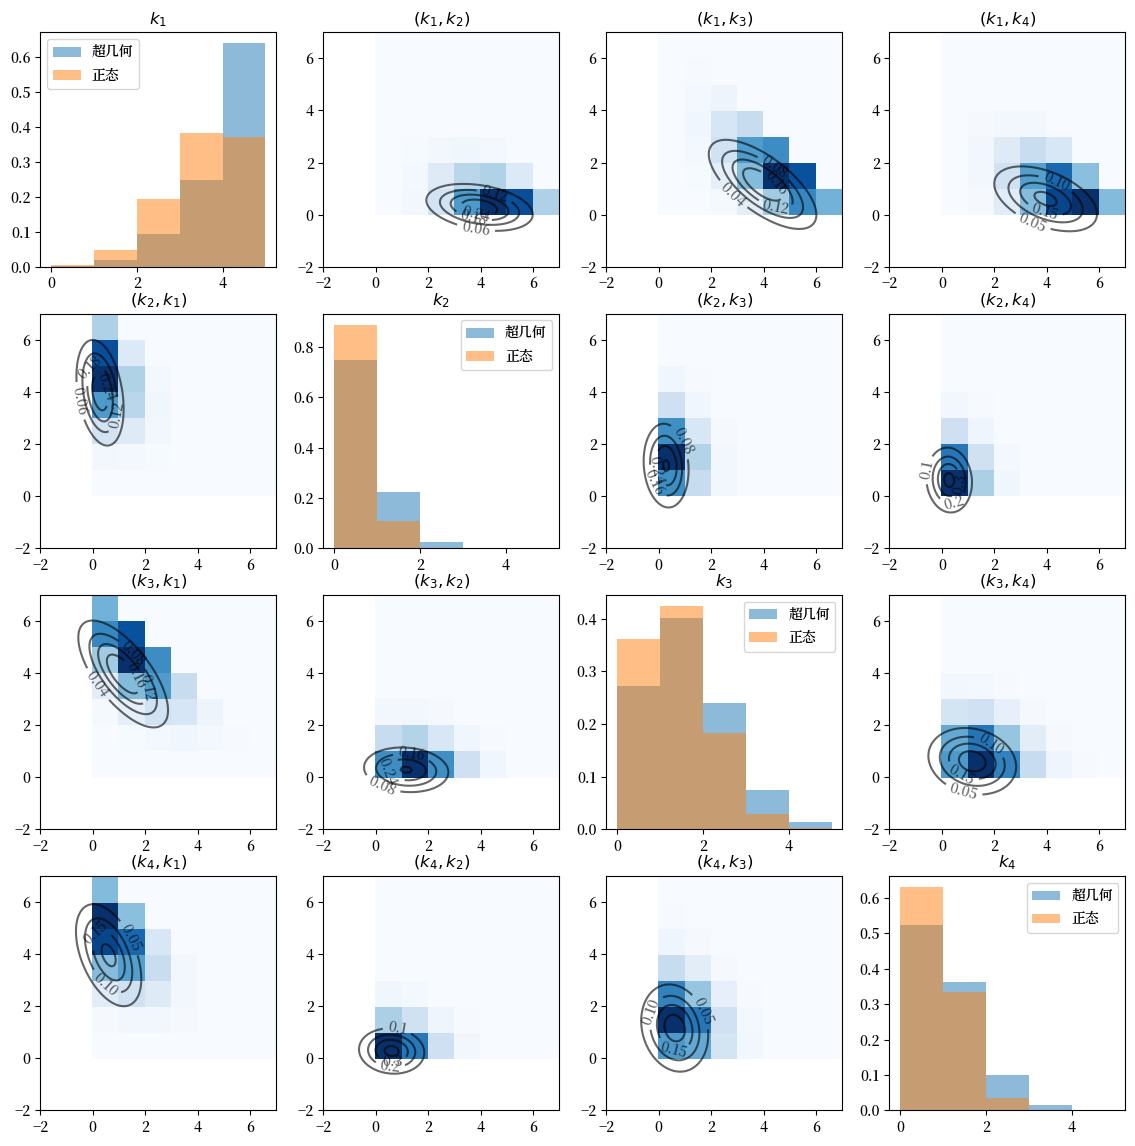

In [21]:
c = urn.c
fig, axs = plt.subplots(c, c, figsize=(14, 14))

# 用于绘制二元高斯分布的网格
x_grid = np.linspace(-2, n+1, 100)
y_grid = np.linspace(-2, n+1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

for i in range(c):
    axs[i, i].hist(sample[:, i], bins=np.arange(0, n, 1), alpha=0.5, density=True, label='超几何')
    axs[i, i].hist(sample_normal[:, i], bins=np.arange(0, n, 1), alpha=0.5, density=True, label='正态')
    axs[i, i].legend()
    axs[i, i].set_title('$k_{' +str(i+1) +'}$')
    for j in range(c):
        if i == j:
            continue

        # 二元高斯密度函数
        Z = bivariate_normal(X, Y, μ, Σ, i, j)
        cs = axs[i, j].contour(X, Y, Z, 4, colors="black", alpha=0.6)
        axs[i, j].clabel(cs, inline=1, fontsize=10)

        # 经验多元超几何分布
        count_mat = count(sample[:, i], sample[:, j], n)
        axs[i, j].pcolor(count_mat.T/size, cmap='Blues')
        axs[i, j].set_title('$(k_{' +str(i+1) +'}, k_{' + str(j+1) + '})$')

plt.show()

对角线图使用直方图绘制每个$k_i$的边际分布。

注意超几何分布与近似正态分布之间存在显著差异。

非对角线图为每对$(i, j)$绘制$k_i$和$k_j$的经验联合分布。

蓝色越深，表示相应单元格中包含的数据点越多。（注意$k_i$在x轴上，$k_j$在y轴上）。

等高线图绘制了$\left(k_i, k_j\right)$的二元高斯密度函数，其中总体均值和协方差由我们上面计算的$\mu$和$\Sigma$的切片给出。

让我们也使用`scipy.stats.normaltest`对每个$k_i$进行正态性检验，该检验实现了D'Agostino和Pearson的检验方法，将偏度和峰度结合起来形成正态性的综合检验。

原假设是样本服从正态分布。

> `normaltest` 返回与每个 $k_i$ 样本测试相关的p值数组。

In [22]:
test_multihyper = normaltest(sample)
test_multihyper.pvalue

array([0., 0., 0., 0.])

正如我们所见，所有p值几乎都是 $0$，零假设被明确地拒绝。

相比之下，来自正态分布的样本并不拒绝零假设。

In [23]:
test_normal = normaltest(sample_normal)
test_normal.pvalue

array([0.396904  , 0.14906778, 0.78170782, 0.24231568])

从这里得到的教训是，正态近似并不完美。